# Predicting Flight Delays: Helping Customers Make Smarter Travel Decisions

The goal of this project is to build a predictive model using the Airline Reporting Carrier On-Time Performance dataset to help travelers identify flights with the lowest risk of delay. 

By analyzing historical flight data—including departure delays, arrival delays, weather conditions, flight distances, and airline carriers—the project aims to uncover key factors affecting on-time performance and provide actionable recommendations for flight booking decisions.

Through building predictive models and interpreting insights from the data, the project seeks to assist customers in making informed flight choices, minimizing the risk of delays, and enhancing travel reliability. Ultimately, this project demonstrates how data science can transform raw information into practical solutions for real-world decision-making.

## Part 1. Understanding the Data

In [184]:
# Load libraries
install.packages("tidyverse")
install.packages("tidymodels")
install.packages("rlang")
install.packages("Metrics")
install.packages("glmnet")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘RcppEigen’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [185]:
# Training and test sets in tidymodels:
library(tidyverse)
library(tidymodels)
library(rlang)
library(Metrics)
library(glmnet)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8



In [65]:
# Load data
sub_airline <- read_csv(
  'lax_to_jfk.csv',
  col_types = cols(
    DivDistance = col_number(),
    DivArrDelay = col_number()
  )
)

head(sub_airline, 10)

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA
12,1,2012-12-03,VX,LAX,JFK,1040,1900,1038,1901,⋯,1,NA,NA,NA,NA,NA,-2,0,NA,NA
12,3,2004-12-01,HP,LAX,JFK,2200,0613,2158,0533,⋯,0,NA,NA,NA,NA,NA,-2,0,NA,NA
2,4,1997-02-13,UA,LAX,JFK,0800,1615,0802,1640,⋯,25,NA,NA,NA,NA,NA,2,2,NA,NA


In [66]:
# Calculate the average carrier delay in January for each reporting airline
sub_airline %>%
filter (Month == 1) %>%
group_by (Reporting_Airline) %>%
summarize(avg_carrier_delay = mean (CarrierDelay, na.rm = TRUE) )


Reporting_Airline,avg_carrier_delay
<chr>,<dbl>
AA,24.625000
AS,32.000000
B6,25.500000
DL,0.000000
HP,0.000000
PA (1),NaN
TW,NaN
UA,0.000000
VX,2.333333


In [67]:
glimpse(sub_airline)

Rows: 2,855
Columns: 21
$ Month             <dbl> 3, 11, 8, 4, 11, 4, 12, 12, 2, 3, 10, 8, 6, 2, 8, 3,…
$ DayOfWeek         <dbl> 5, 4, 5, 7, 3, 1, 1, 3, 4, 4, 4, 5, 4, 3, 7, 6, 4, 4…
$ FlightDate        <date> 2003-03-28, 2018-11-29, 2015-08-28, 2003-04-20, 200…
$ Reporting_Airline <chr> "UA", "AS", "UA", "DL", "UA", "UA", "VX", "HP", "UA"…
$ Origin            <chr> "LAX", "LAX", "LAX", "LAX", "LAX", "LAX", "LAX", "LA…
$ Dest              <chr> "JFK", "JFK", "JFK", "JFK", "JFK", "JFK", "JFK", "JF…
$ CRSDepTime        <chr> "2210", "1045", "0805", "2205", "0840", "1450", "104…
$ CRSArrTime        <chr> "0615", "1912", "1634", "0619", "1653", "2308", "190…
$ DepTime           <chr> "2209", "1049", "0757", "2212", "0836", "1452", "103…
$ ArrTime           <chr> "0617", "1851", "1620", "0616", "1640", "2248", "190…
$ ArrDelay          <dbl> 2, -21, -14, -3, -13, -20, 1, -40, 25, 7, 5, 34, 21,…
$ ArrDelayMinutes   <dbl> 2, 0, 0, 0, 0, 0, 1, 0, 25, 7, 5, 34, 21, 0, 14, 682…
$ CarrierDelay  

In [68]:
sub_airline %>%
group_by (Reporting_Airline) %>%
summarize(avg_carrier_delay = mean (CarrierDelay, na.rm = TRUE) )


Reporting_Airline,avg_carrier_delay
<chr>,<dbl>
AA,19.643478
AS,14.833333
B6,11.466667
DL,24.912088
HP,3.333333
PA (1),NaN
TW,NaN
UA,14.509804
VX,14.941176


In [69]:
sub_airline %>%
group_by (Reporting_Airline) %>%
summarize(sd_carrier_delay = sd (CarrierDelay, na.rm = TRUE) )


Reporting_Airline,sd_carrier_delay
<chr>,<dbl>
AA,36.047287
AS,19.039831
B6,29.040280
DL,99.775375
HP,8.164966
PA (1),NA
TW,NA
UA,35.396821
VX,39.813917


## Part 2. Data Wrangling

We can add values to specific entries in a column, and if values are not specified for all columns, R fills them with "NA" by default.

In [73]:
head(sub_airline, 10)

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA
12,1,2012-12-03,VX,LAX,JFK,1040,1900,1038,1901,⋯,1,NA,NA,NA,NA,NA,-2,0,NA,NA
12,3,2004-12-01,HP,LAX,JFK,2200,0613,2158,0533,⋯,0,NA,NA,NA,NA,NA,-2,0,NA,NA
2,4,1997-02-13,UA,LAX,JFK,0800,1615,0802,1640,⋯,25,NA,NA,NA,NA,NA,2,2,NA,NA


In [74]:
sub_airline %>% add_row('ArrDelay' = 0, .before = 1)
head(sub_airline, 10)

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA
12,1,2012-12-03,VX,LAX,JFK,1040,1900,1038,1901,⋯,1,NA,NA,NA,NA,NA,-2,0,NA,NA
12,3,2004-12-01,HP,LAX,JFK,2200,0613,2158,0533,⋯,0,NA,NA,NA,NA,NA,-2,0,NA,NA


Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,2,NA,NA,NA,NA,NA,-1,0,NA,NA
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,NA,NA,NA,NA,NA,4,4,NA,NA
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,NA,NA,NA,NA,NA,-8,0,NA,NA
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,NA,NA,NA,NA,NA,7,7,NA,NA
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,NA,NA,NA,NA,NA,-4,0,NA,NA
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,NA,NA,NA,NA,NA,2,2,NA,NA
12,1,2012-12-03,VX,LAX,JFK,1040,1900,1038,1901,⋯,1,NA,NA,NA,NA,NA,-2,0,NA,NA
12,3,2004-12-01,HP,LAX,JFK,2200,0613,2158,0533,⋯,0,NA,NA,NA,NA,NA,-2,0,NA,NA
2,4,1997-02-13,UA,LAX,JFK,0800,1615,0802,1640,⋯,25,NA,NA,NA,NA,NA,2,2,NA,NA


In [75]:
# counting missing values in all columns
sub_airline %>% map(~sum(is.na (.)))

$Month
[1] 0

$DayOfWeek
[1] 0

$FlightDate
[1] 0

$Reporting_Airline
[1] 0

$Origin
[1] 0

$Dest
[1] 0

$CRSDepTime
[1] 0

$CRSArrTime
[1] 0

$DepTime
[1] 0

$ArrTime
[1] 0

$ArrDelay
[1] 0

$ArrDelayMinutes
[1] 0

$CarrierDelay
[1] 2486

$WeatherDelay
[1] 2486

$NASDelay
[1] 2486

$SecurityDelay
[1] 2486

$LateAircraftDelay
[1] 2486

$DepDelay
[1] 0

$DepDelayMinutes
[1] 0

$DivDistance
[1] 2855

$DivArrDelay
[1] 2855

In our dataset, columns DivDistance and DivArDelay are nearly all empty so we will drop them entirely. So, we are goind to drop the whole column:
- "DivDistance": 2855 missing data
- "DivArrDelay": 2855 missing data


In [99]:
drop_na_cols <- sub_airline %>% select(-DivDistance, -DivArrDelay)
dim (drop_na_cols)
head (drop_na_cols)

[1] 2855   22

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,year,month,day
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,0,0,0,0,0,-1,0,2003,3,28
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,0,0,0,0,4,4,2018,11,29
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,0,0,0,0,-8,0,2015,8,28
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,0,0,0,0,7,7,2003,4,20
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,0,0,0,0,-4,0,2005,11,30
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,0,0,0,0,2,2,1992,4,6


In [100]:
# Replace the missing values in five columns 
sub_airline <- sub_airline %>%
  replace_na(list(
    CarrierDelay = 0,
    WeatherDelay = 0,
    NASDelay = 0,
    SecurityDelay = 0,
    LateAircraftDelay = 0
  ))

In [101]:
head(sub_airline, 10)

Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay,year,month,day
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,5,2003-03-28,UA,LAX,JFK,2210,0615,2209,0617,⋯,0,0,0,-1,0,NA,NA,2003,3,28
11,4,2018-11-29,AS,LAX,JFK,1045,1912,1049,1851,⋯,0,0,0,4,4,NA,NA,2018,11,29
8,5,2015-08-28,UA,LAX,JFK,0805,1634,0757,1620,⋯,0,0,0,-8,0,NA,NA,2015,8,28
4,7,2003-04-20,DL,LAX,JFK,2205,0619,2212,0616,⋯,0,0,0,7,7,NA,NA,2003,4,20
11,3,2005-11-30,UA,LAX,JFK,0840,1653,0836,1640,⋯,0,0,0,-4,0,NA,NA,2005,11,30
4,1,1992-04-06,UA,LAX,JFK,1450,2308,1452,2248,⋯,0,0,0,2,2,NA,NA,1992,4,6
12,1,2012-12-03,VX,LAX,JFK,1040,1900,1038,1901,⋯,0,0,0,-2,0,NA,NA,2012,12,3
12,3,2004-12-01,HP,LAX,JFK,2200,0613,2158,0533,⋯,0,0,0,-2,0,NA,NA,2004,12,1
2,4,1997-02-13,UA,LAX,JFK,0800,1615,0802,1640,⋯,0,0,0,2,2,NA,NA,1997,2,13


In [104]:
# identify data types: 
sapply(sub_airline, typeof)

Month         DayOfWeek        FlightDate Reporting_Airline 
         "double"          "double"          "double"       "character" 
           Origin              Dest        CRSDepTime        CRSArrTime 
      "character"       "character"       "character"       "character" 
          DepTime           ArrTime          ArrDelay   ArrDelayMinutes 
      "character"       "character"          "double"          "double" 
     CarrierDelay      WeatherDelay          NASDelay     SecurityDelay 
         "double"          "double"          "double"          "double" 
LateAircraftDelay          DepDelay   DepDelayMinutes       DivDistance 
         "double"          "double"          "double"          "double" 
      DivArrDelay              year             month               day 
         "double"          "double"          "double"         "integer"

Split a date column (e.g., "FlightDate") into separate columns for year, month, and day.

In [105]:
date_airline <- drop_na_cols %>%
  separate(FlightDate, sep = "-", into = c("year", "month", "day"))

head (date_airline)

Month,DayOfWeek,year,month,day,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,⋯,ArrTime,ArrDelay,ArrDelayMinutes,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003,03,28,UA,LAX,JFK,2210,0615,⋯,0617,2,2,0,0,0,0,0,-1,0
11,4,2018,11,29,AS,LAX,JFK,1045,1912,⋯,1851,-21,0,0,0,0,0,0,4,4
8,5,2015,08,28,UA,LAX,JFK,0805,1634,⋯,1620,-14,0,0,0,0,0,0,-8,0
4,7,2003,04,20,DL,LAX,JFK,2205,0619,⋯,0616,-3,0,0,0,0,0,0,7,7
11,3,2005,11,30,UA,LAX,JFK,0840,1653,⋯,1640,-13,0,0,0,0,0,0,-4,0
4,1,1992,04,06,UA,LAX,JFK,1450,2308,⋯,2248,-20,0,0,0,0,0,0,2,2


In the airline dataset, the "Reporting_Airline" feature is a categorical variable that has nine values, "AA", "AS", "B6", "DL", "HP", "PA (1)", "TW", "UA" or "VX", which are in character type.
For further analysis, we need to convert these categorical variables into some form of numeric format which is crucial for models that don’t handle categorical variables natively.


In [108]:
sub_airline %>%
    spread (Reporting_Airline, ArrDelay) %>% 
         slice (1:5)

Month,DayOfWeek,FlightDate,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,ArrDelayMinutes,⋯,day,AA,AS,B6,DL,HP,PA (1),TW,UA,VX
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,LAX,JFK,2210,0615,2209,0617,2,⋯,28,NA,NA,NA,NA,NA,NA,NA,2,NA
11,4,2018-11-29,LAX,JFK,1045,1912,1049,1851,0,⋯,29,NA,-21,NA,NA,NA,NA,NA,NA,NA
8,5,2015-08-28,LAX,JFK,0805,1634,0757,1620,0,⋯,28,NA,NA,NA,NA,NA,NA,NA,-14,NA
4,7,2003-04-20,LAX,JFK,2205,0619,2212,0616,0,⋯,20,NA,NA,NA,-3,NA,NA,NA,NA,NA
11,3,2005-11-30,LAX,JFK,0840,1653,0836,1640,0,⋯,30,NA,NA,NA,NA,NA,NA,NA,-13,NA


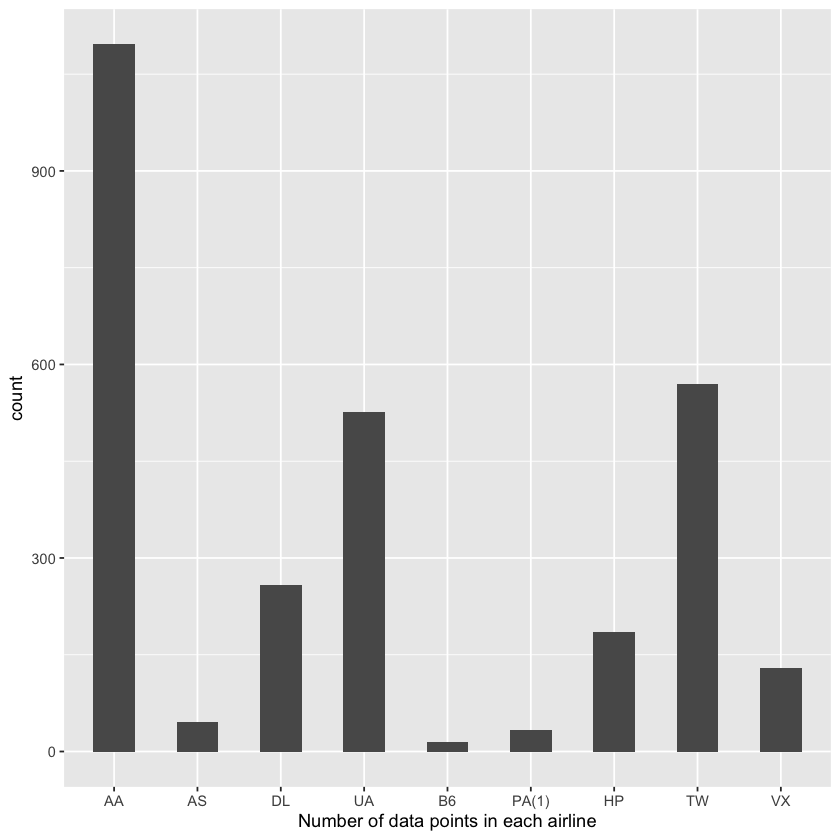

In [109]:
# visualize airline category distribution
sub_airline %>% # start with data
      mutate (Reporting_Airline = factor (Reporting_Airline,
                     labels = c("AA", "AS", "DL", "UA", "B6", "PA(1)", "HP", "TW", "VX")))%>%
ggplot(aes (Reporting_Airline)) +
stat_count (width = 0.5) +
labs (x = "Number of data points in each airline")

In [110]:
sub_airline %>%
      mutate(dummy = 1) %>% # column with single value
      spread (key = Reporting_Airline, # column to spread
                    value = dummy, fill = 0) %>%
      slice (1:5)


Month,DayOfWeek,FlightDate,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,ArrDelay,⋯,day,AA,AS,B6,DL,HP,PA (1),TW,UA,VX
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,5,2003-03-28,LAX,JFK,2210,0615,2209,0617,2,⋯,28,0,0,0,0,0,0,0,1,0
11,4,2018-11-29,LAX,JFK,1045,1912,1049,1851,-21,⋯,29,0,1,0,0,0,0,0,0,0
8,5,2015-08-28,LAX,JFK,0805,1634,0757,1620,-14,⋯,28,0,0,0,0,0,0,0,1,0
4,7,2003-04-20,LAX,JFK,2205,0619,2212,0616,-3,⋯,20,0,0,0,1,0,0,0,0,0
11,3,2005-11-30,LAX,JFK,0840,1653,0836,1640,-13,⋯,30,0,0,0,0,0,0,0,1,0


## Part 3. Exploratory Data Analysis

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”


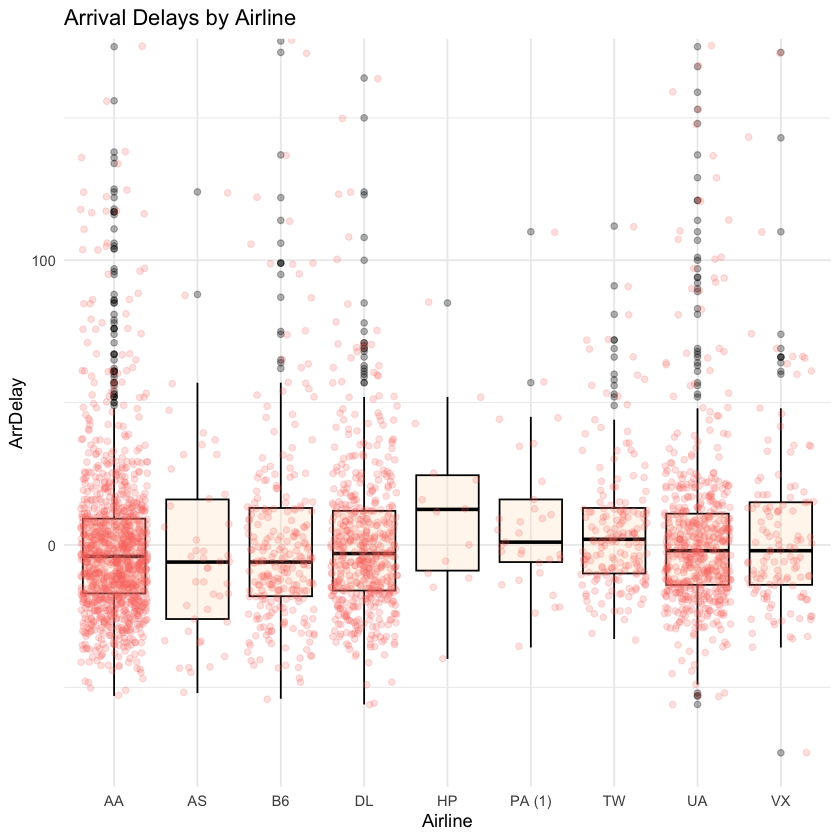

In [111]:
# Display distribution of arrival delays for each reporting airline
ggplot (data = sub_airline, mapping = aes (x = Reporting_Airline, y = ArrDelay)) +
    geom_boxplot (fill = "bisque", color = "black", alpha = 0.3) +
    geom_jitter(aes (color = 'blue'), alpha=0.2) +
    labs (x = "Airline") +
    ggtitle("Arrival Delays by Airline") +
    guides (color = FALSE) +
    theme_minimal () +
    coord_cartesian (ylim = quantile(sub_airline$ArrDelay, c(0, 0.99)))


Let's understand the relationship between "DepDelay" and "ArrDelay". 
Determine whether departure delays can be used to predict arrival delays.

`geom_smooth()` using formula = 'y ~ x'


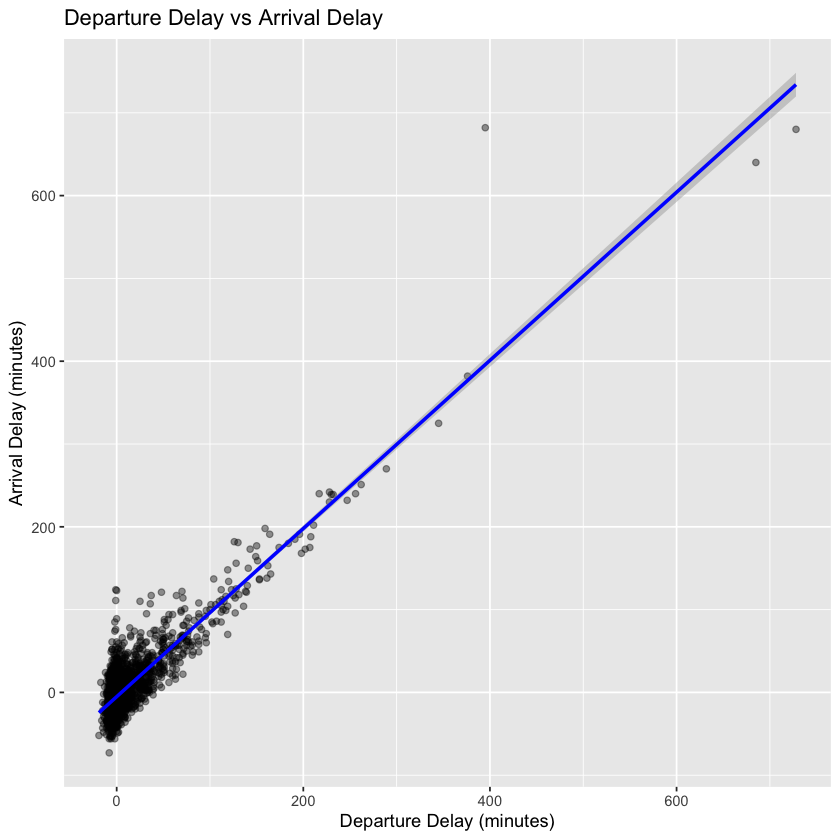

In [112]:
# visualize relationship between "DepDelay" and "ArrDelay"
ggplot(sub_airline, aes(x = DepDelay, y = ArrDelay)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm", se = TRUE, color = "blue") +
  labs(
    title = "Departure Delay vs Arrival Delay",
    x = "Departure Delay (minutes)",
    y = "Arrival Delay (minutes)"
  )

In [113]:
# calculate the correlation
cor(sub_airline$DepDelay, sub_airline$ArrDelay, use = "complete.obs")

[1] 0.8826109

The correlation between "DepDelay" and "ArrDelay" is around 0.89 which means that the relationship is strong. In addition, most of the time, flights that depart late also arrive late, especially over long distances. However, buffer times and air traffic management can absorb some of the departure delay.

Let's examine if "WeatherDelay" is a good predictor variable of "ArrDelayMinutes".

`geom_smooth()` using formula = 'y ~ x'


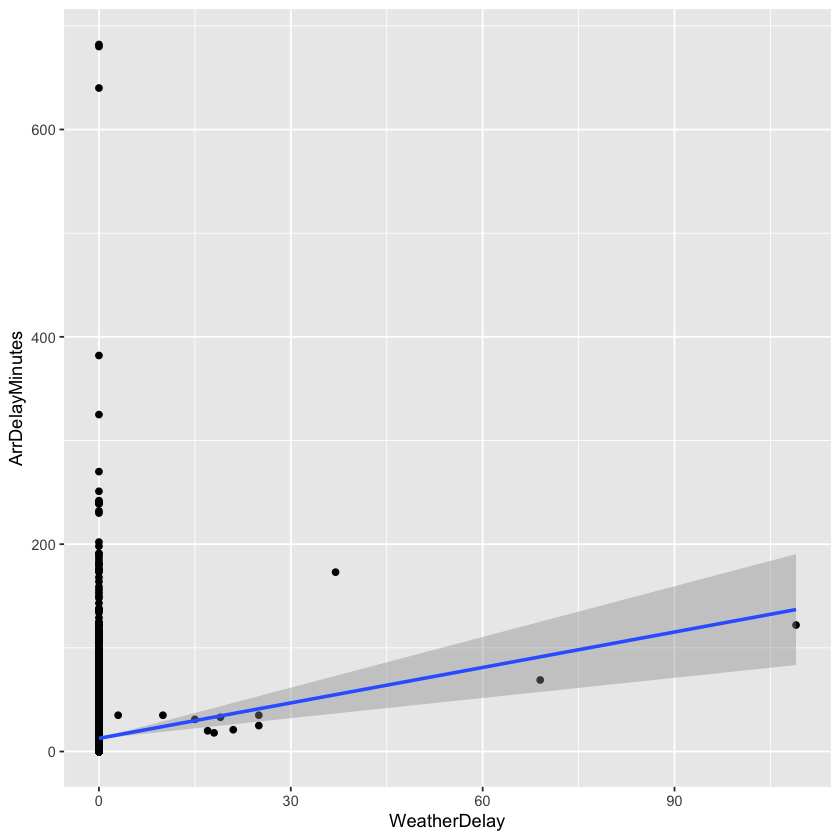

In [115]:
ggplot (data = sub_airline, mapping  = aes(x = WeatherDelay, y = ArrDelayMinutes)) + 
    geom_point () +
    geom_smooth (method = "lm", na.rm = TRUE)

Arrival delay is weakly positively related to weather delay. Weather delay does not seem like a good predictor of arrival delay minutes.

Let's group the the data by Reporting_Airline and calculates the mean, the standard deviation and the quartiles of ArrDelayMinutes.

This gives us a summary statistics table showing the average arrival delay and variability per airline and identify which airlines tend to be more consistent or more delayed.

In [120]:
summary_airline_delays <- sub_airline %>%
  group_by(Reporting_Airline) %>%
  summarize(
    count = n(),
    mean = mean(ArrDelayMinutes, na.rm = TRUE),
    std_dev = sd(ArrDelayMinutes, na.rm = TRUE),
    min = min(ArrDelayMinutes, na.rm = TRUE),
    median = median(ArrDelayMinutes, na.rm = TRUE),
    iqr = IQR(ArrDelayMinutes, na.rm = TRUE),
    max = max(ArrDelayMinutes, na.rm = TRUE)
  )

summary_airline_delays

Reporting_Airline,count,mean,std_dev,min,median,iqr,max
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AA,1096,10.12226,24.95855,0,0.0,9.25,325
AS,45,12.91111,25.59903,0,0.0,16.00,124
B6,258,18.55039,47.14758,0,0.0,13.00,382
DL,526,13.83650,48.08742,0,0.0,12.00,680
HP,14,19.21429,25.31700,0,12.5,24.50,85
PA (1),33,33.54545,118.73265,0,1.0,16.00,682
TW,185,15.59459,36.82041,0,2.0,13.00,270
UA,569,11.73462,27.09474,0,0.0,11.00,191
VX,129,14.93798,31.14125,0,0.0,15.00,188


- AA (American Airlines) has the largest sample size (1096) and a relatively low mean delay (~10.1 minutes), with median = 0, implying most flights are on time or early.
- PA(1) shows the highest mean delay (35.5 minutes) and highest standard deviation (118.7), indicating wide variability and potentially problematic reliability.
- DL, B6, and TW have higher maximum delays (up to 680 mins), but the medians are low, suggesting only a few extreme cases skew the average.

Let's identify patterns of delay behavior across different airlines (Reporting_Airline) and days of the week (DayOfWeek). This will help us answer questions like:
- Which airline is generally more delayed?
- Are delays worse on certain days (e.g., weekends or Mondays)?
- Which airline-day combinations are the most problematic?


In [122]:
# Group by Reporting_Airline and DayOfWeek, then calculate mean arrival delays
avg_delays <- sub_airline %>%
  group_by(Reporting_Airline, DayOfWeek) %>%
  summarize(mean_delays = mean(ArrDelayMinutes, na.rm = TRUE), .groups = 'keep')

# View first few rows
head(avg_delays)

# Sort by highest average delays
sorted <- avg_delays %>%
  arrange(desc(mean_delays))

# View sorted result
head(sorted)

Reporting_Airline,DayOfWeek,mean_delays
<chr>,<dbl>,<dbl>
AA,1,9.186813
AA,2,6.232558
AA,3,7.289157
AA,4,12.387500
AA,5,15.949640
AA,6,8.000000


Reporting_Airline,DayOfWeek,mean_delays
<chr>,<dbl>,<dbl>
PA (1),6,121.83333
PA (1),5,36.50000
TW,6,34.80952
B6,7,26.82051
HP,5,26.00000
VX,2,25.65217


- The highest average delays are dominated by airline “PA(1)”, especially on Day 6 (Saturday), with over 121 minutes of delay which is a major outlier.
- Other airlines like TW, B6, and VX also show high average delays on specific days.
- Airline “AA” (American Airlines) shows relatively lower average delays, ranging from about 6 to 16 minutes.

Let's visualize this using a heatmap for clearer comparisons across airlines and days.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


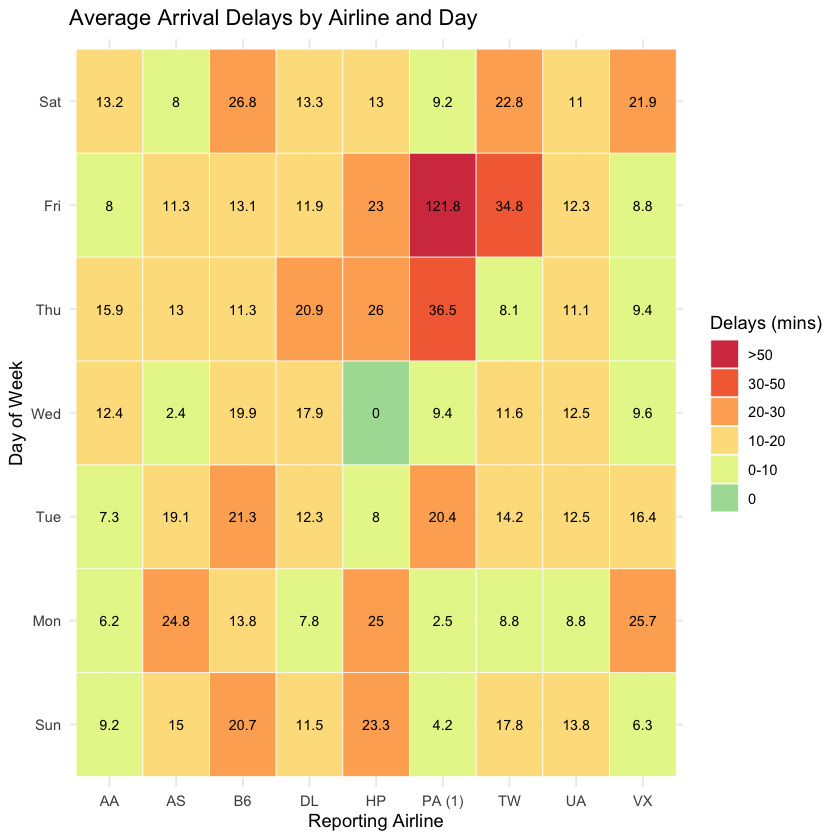

In [123]:
library(dplyr)
library(ggplot2)
library(lubridate)

# Group, summarize, and bin delays
avg_delays <- sub_airline %>%
  group_by(Reporting_Airline, DayOfWeek) %>%
  summarize(mean_delays = mean(ArrDelayMinutes, na.rm = TRUE), .groups = 'keep') %>%
  mutate(
    bins = cut(
      mean_delays,
      breaks = c(-0.1, 0.1, 10, 20, 30, 50, max(mean_delays, na.rm = TRUE)),
      labels = c("0", "0-10", "10-20", "20-30", "30-50", ">50"),
      include.lowest = TRUE
    ),
    bins = factor(as.character(bins), levels = rev(levels(bins)))
  )

# Plot heatmap
ggplot(avg_delays, aes(
  x = Reporting_Airline,
  y = wday(DayOfWeek, label = TRUE),
  fill = bins
)) +
  geom_tile(colour = "white", size = 0.2) +
  geom_text(aes(label = round(mean_delays, 1)), size = 3) +
  guides(fill = guide_legend(title = "Delays (mins)")) +
  labs(
    x = "Reporting Airline",
    y = "Day of Week",
    title = "Average Arrival Delays by Airline and Day"
  ) +
  scale_fill_manual(values = c("#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4")) +
  theme_minimal()

Next, let's perform an ANOVA test confirming the significance of differences in flight delays between airlines.

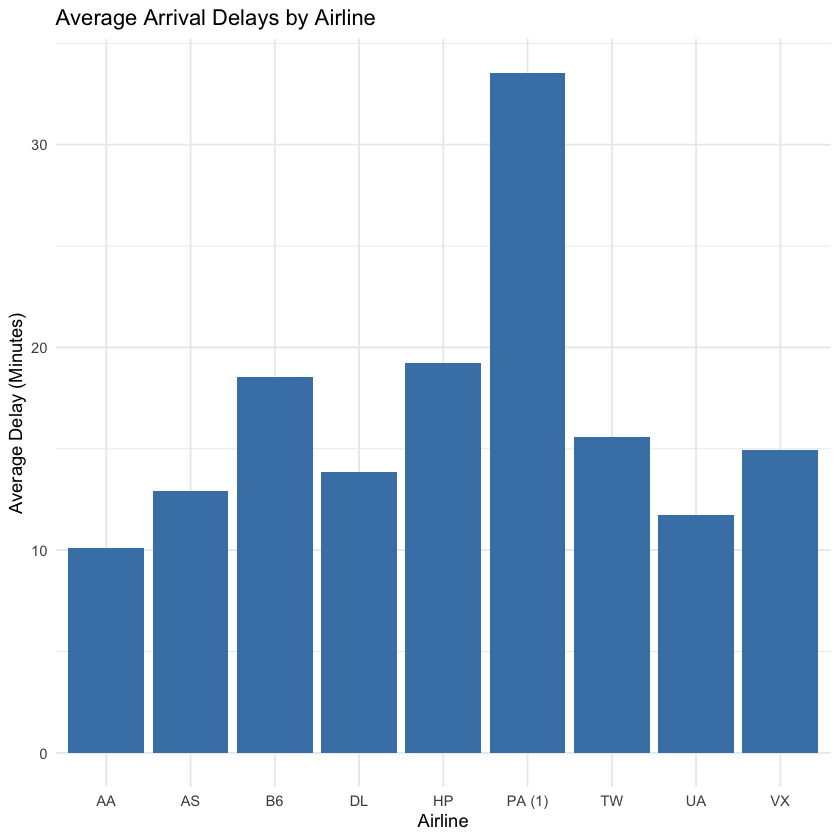

In [125]:
# Summarize average delays by airline
summary_airline_delays <- sub_airline %>% 
  group_by(Reporting_Airline) %>%
  summarize(Average_Delays = mean(ArrDelayMinutes, na.rm = TRUE))

# Plot bar chart
summary_airline_delays %>%
  ggplot(aes(x = Reporting_Airline, y = Average_Delays)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  ggtitle("Average Arrival Delays by Airline") +
  xlab("Airline") +
  ylab("Average Delay (Minutes)") +
  theme_minimal()

From the bar chart, we can conclude that the F-test score is small between AA and AS while it's large between AA and PA(1) because the differences between the average delay is very significant.

Although the bar chart can give us a visual sense of delay differences, ANOVA test allows us to formally test if those observed differences are statistically significant.


In [126]:
# Step 1: Subset data to include only AA and AS
aa_as_subset <- sub_airline %>%
  select(ArrDelay, Reporting_Airline) %>%
  filter(Reporting_Airline == 'AA' | Reporting_Airline == 'AS')

# Step 2: Perform ANOVA test
ad_aov <- aov(ArrDelay ~ Reporting_Airline, data = aa_as_subset)

# Step 3: Show summary of ANOVA
summary(ad_aov)

                    Df  Sum Sq Mean Sq F value Pr(>F)
Reporting_Airline    1     126   125.7    0.13  0.718
Residuals         1139 1097707   963.7               

F-value is very low and p-value is much greater than 0.05. S0, there is no statistically significant difference in average arrival delays between American Airlines (AA) and Alaska Airlines (AS) and confirms the earlier visual interpretation from the bar chart.

In [127]:
# Subset the data for AA and PA (1)
aa_pa_subset <- sub_airline %>%
  select(ArrDelay, Reporting_Airline) %>%
  filter(Reporting_Airline == "AA" | Reporting_Airline == "PA (1)")

# Perform ANOVA
ad_aov <- aov(ArrDelay ~ Reporting_Airline, data = aa_pa_subset)

# View the ANOVA summary
summary(ad_aov)

                    Df  Sum Sq Mean Sq F value   Pr(>F)    
Reporting_Airline    1   24008   24008   17.95 2.45e-05 ***
Residuals         1127 1507339    1337                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Large F-stat value indicates strong variation between groups and a very small p-value means that there is a statistically significant difference in arrival delays between AA and PA (1).This confirms again that our earlier observation from the bar plot: PA (1) flights tend to have much higher delays than AA.


## Part 4. Model development 

As we move forward with building machine learning models, it’s important to select features that strongly influence our target variable which will enhance the model’s accuracy and overall performance.

Let's look at how departure delay (DepDelay Minutes) can help us predict arrival delay (ArrDelayMinutes) by using a simple linear regression.

In [138]:
# Define the dataset as aa_delay with just AA as the reporting_Airline
aa_delays <- sub_airline %>%
       filter (CarrierDelay != "NA", Reporting_Airline == "AA")
head(aa_delays)


Month,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,DepTime,ArrTime,⋯,NASDelay,SecurityDelay,LateAircraftDelay,DepDelay,DepDelayMinutes,DivDistance,DivArrDelay,year,month,day
<dbl>,<dbl>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
10,4,1999-10-14,AA,LAX,JFK,2300,0717,2302,0722,⋯,0,0,0,2,2,NA,NA,1999,10,14
6,4,2006-06-01,AA,LAX,JFK,1515,2332,1507,2353,⋯,21,0,0,-8,0,NA,NA,2006,6,1
2,3,1999-02-03,AA,LAX,JFK,0700,1508,0658,1448,⋯,0,0,0,-2,0,NA,NA,1999,2,3
8,7,1995-08-27,AA,LAX,JFK,0900,1715,0859,1729,⋯,0,0,0,-1,0,NA,NA,1995,8,27
6,4,1996-06-13,AA,LAX,JFK,0700,1507,0659,1511,⋯,0,0,0,-1,0,NA,NA,1996,6,13
7,4,2003-07-24,AA,LAX,JFK,2315,0736,2311,0735,⋯,0,0,0,-4,0,NA,NA,2003,7,24


In [139]:
# Fit the data into linear regression model:
linear_model <- lm(ArrDelayMinutes ~ DepDelayMinutes, data = aa_delays)

# Summarize the regression model:
summary (linear_model)


Call:
lm(formula = ArrDelayMinutes ~ DepDelayMinutes, data = aa_delays)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.056  -2.548  -2.548   0.589 108.452 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      2.54783    0.37616   6.773 2.05e-11 ***
DepDelayMinutes  0.88560    0.01432  61.852  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.77 on 1094 degrees of freedom
Multiple R-squared:  0.7776,	Adjusted R-squared:  0.7774 
F-statistic:  3826 on 1 and 1094 DF,  p-value: < 2.2e-16


Let's generate predictions from a simple linear model based on new unseen data. We are going to use a trained linear regression model to predict arrival delay from new departure delay values (DepDelayMinutes = 12, 19, 24).

In [140]:
# 1. Create new data frame with unseen departure delays
new_depdelay <- data.frame(DepDelayMinutes = c(12, 19, 24))

# 2. Predict arrival delays using the trained linear model
pred <- predict(linear_model, newdata = new_depdelay, interval = "confidence")
pred

,fit,lwr,upr
1,13.17498,12.47042,13.87955
2,19.37416,18.61707,20.13124
3,23.80214,22.98033,24.62394


If a flight departs 12 minutes late, the model predicts it will arrive around 13.2 minutes late, with 95% confidence the actual delay falls between 12.5 and 13.9 minutes. This reflects a positive linear relationship between departure and arrival delays.

Let's build a multiple linear regression model to predict ArrDelayMinutes using two predictors: CarrierDelay and LateAircraftDelay. 

In [143]:
# build the new model
mlr <- lm(ArrDelayMinutes ~ CarrierDelay + LateAircraftDelay, data = aa_delays)
summary(mlr)


Call:
lm(formula = ArrDelayMinutes ~ CarrierDelay + LateAircraftDelay, 
    data = aa_delays)

Residuals:
   Min     1Q Median     3Q    Max 
-10.90  -7.07  -7.07  -0.07 317.93 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        7.07168    0.58037   12.19   <2e-16 ***
CarrierDelay       0.97249    0.04368   22.27   <2e-16 ***
LateAircraftDelay  1.02190    0.06218   16.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.89 on 1093 degrees of freedom
Multiple R-squared:  0.4284,	Adjusted R-squared:  0.4274 
F-statistic: 409.7 on 2 and 1093 DF,  p-value: < 2.2e-16


In [144]:
# Create new data using CarrierDelay and LateAircraftDelay
CarrierDelay <- c(10, 20, 30)
LateAircraftDelay <- c(20, 60, 30)
new_multidelay <- data.frame(CarrierDelay, LateAircraftDelay)

In [145]:
# calculate predictions
pred <- predict(mlr, newdata = new_multidelay, interval = "confidence")
pred

,fit,lwr,upr
1,37.23468,34.61513,39.85424
2,87.83578,80.49499,95.17656
3,66.90355,62.62164,71.18546


- When CarrierDelay is 10 minutes and LateAircraftDelay is 20 minutes, then predicted Arrival delay is 37 minutes. And we are 95% confident that the interval (34.62, 39.85) captures the true mean arrival delay for this instance.
- The combination of both delay sources significantly influences total arrival delays.
- Observation 2 (CarrierDelay = 20mn and LateAircraftDelay = 60mn is 20) has the highest predicted delay due to both predictors being large.

Let's create and train a MLR model where the response variable is ArrDelayMinutes, and the 3 predictor variables: 'DepDelayMinutes', 'LateAircraftDelay' and 'CarrierDelay'.

In [148]:
mlr2 <- lm(ArrDelayMinutes ~ CarrierDelay + LateAircraftDelay + DepDelayMinutes, data = aa_delays)
summary(mlr2)


Call:
lm(formula = ArrDelayMinutes ~ CarrierDelay + LateAircraftDelay + 
    DepDelayMinutes, data = aa_delays)

Residuals:
    Min      1Q  Median      3Q     Max 
-37.725  -2.601  -2.601   0.434 108.399 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.60144    0.37681   6.904 8.57e-12 ***
CarrierDelay       0.08477    0.03456   2.453   0.0143 *  
LateAircraftDelay  0.01805    0.04560   0.396   0.6924    
DepDelayMinutes    0.85674    0.02060  41.599  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.75 on 1092 degrees of freedom
Multiple R-squared:  0.7789,	Adjusted R-squared:  0.7783 
F-statistic:  1282 on 3 and 1092 DF,  p-value: < 2.2e-16


In [149]:
# Define the new data points
CarrierDelay <- c(5, 10, 15)  # Add CarrierDelay as required by the model
DepDelayMinutes <- c(10, 20, 30)
LateAircraftDelay <- c(20, 60, 30)

new_multidelay <- data.frame(CarrierDelay, LateAircraftDelay, DepDelayMinutes)

# Predictions using mlr2
pred <- predict(mlr2, newdata = new_multidelay, interval = "confidence")
pred

,fit,lwr,upr
1,11.95361,10.08751,13.81971
2,21.66670,16.41848,26.91493
3,30.11655,27.52977,32.70333


- The model expects around 12 to 30 minutes of arrival delays.
- The 95% confidence intervals show a relatively tight range, suggesting a stable prediction for these input ranges.

To visualize the relationship between DepDelayMinutes and ArrDelayMinutes for AA using a simple linear regression model 

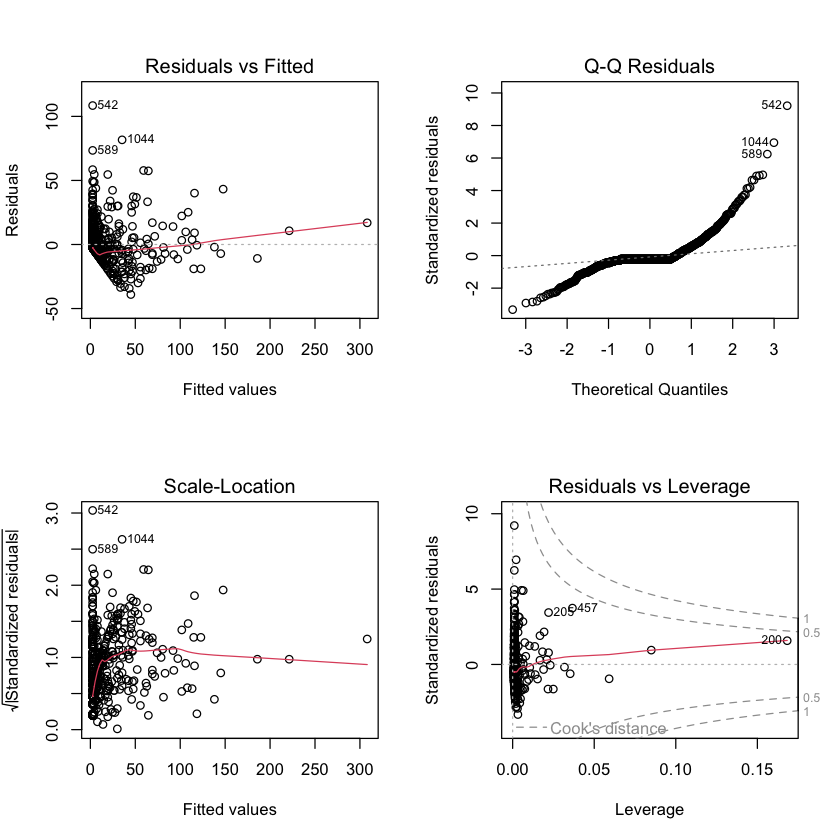

In [153]:
# Fit a linear model for AA delays
linear_model <- lm(ArrDelayMinutes ~ DepDelayMinutes, data = aa_delays)

# Plot the regression diagnostics
par(mfrow = c(2, 2))
plot(linear_model)


`geom_smooth()` using formula = 'y ~ x'


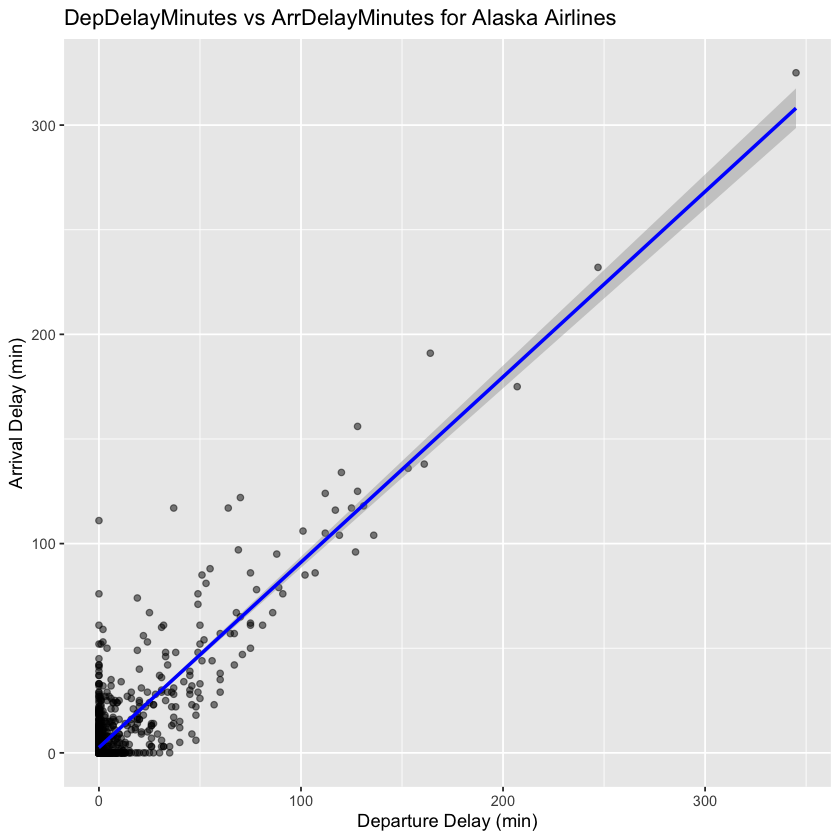

In [152]:
library(ggplot2)

ggplot(aa_delays, aes(x = DepDelayMinutes, y = ArrDelayMinutes)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "lm", se = TRUE, color = "blue") +
  labs(title = "DepDelayMinutes vs ArrDelayMinutes for Alaska Airlines",
       x = "Departure Delay (min)",
       y = "Arrival Delay (min)")

## Part 5. Model Evaluation

We’re currently working on model evaluation by splitting your dataset into training and testing sets and fitting a linear regression model using tidymodels.

In [167]:
# create a cleaned dataset Flight_delays with selected features 
Flight_delays <- sub_airline %>%
  replace_na(list(
    CarrierDelay = 0,
    WeatherDelay = 0,
    NASDelay = 0,
    SecurityDelay = 0,
    LateAircraftDelay = 0
  )) %>%
  select(
    ArrDelayMinutes,
    DepDelayMinutes,
    CarrierDelay,
    WeatherDelay,
    NASDelay,
    SecurityDelay,
    LateAircraftDelay,
    DayOfWeek,
    Month
  )

In [168]:
# split into training and testing sets
library(rsample)

set.seed(1234)  
flight_split <- initial_split(Flight_delays, prop = 0.8)
train_data <- training(flight_split)
test_data <- testing(flight_split)

In [169]:
# specify the model
library(parsnip)

lm_spec <- linear_reg() %>%
  set_engine("lm")  

lm_spec 

Linear Regression Model Specification (regression)

Computational engine: lm 


In [170]:
# Train a linear regression:
train_fit <- lm_spec %>%
  fit(ArrDelayMinutes ~ DepDelayMinutes, data = train_data)

train_fit

parsnip model object


Call:
stats::lm(formula = ArrDelayMinutes ~ DepDelayMinutes, data = data)

Coefficients:
    (Intercept)  DepDelayMinutes  
         2.2981           0.9618  


In [172]:
train_results <- predict(train_fit, new_data = train_data) %>%
  bind_cols(truth = train_data$ArrDelayMinutes)  # combine predictions and true values

head(train_results)

.pred,truth
<dbl>,<dbl>
2.298064,8
2.298064,9
2.298064,27
2.298064,9
13.839911,9
3.259884,0


In [173]:
# Make Predictions on testing set
test_results <- predict(train_fit, new_data = test_data) %>%
  bind_cols(truth = test_data$ArrDelayMinutes)

head(test_results)

.pred,truth
<dbl>,<dbl>
2.298064,0
2.298064,0
2.298064,0
86.938280,95
6.145346,25
4.221705,25


In [176]:
library(yardstick)
library(tibble)

# Compute metrics using yardstick:: prefix to avoid base R conflicts
train_rmse <- yardstick::rmse(train_results, truth = truth, estimate = .pred)
train_rsq  <- yardstick::rsq(train_results, truth = truth, estimate = .pred)

test_rmse <- yardstick::rmse(test_results, truth = truth, estimate = .pred)
test_rsq  <- yardstick::rsq(test_results, truth = truth, estimate = .pred)

# Combine into a tidy table
metrics_table <- tibble(
  Dataset = c("Training", "Testing"),
  RMSE = c(train_rmse$.estimate, test_rmse$.estimate),
  RSQ  = c(train_rsq$.estimate,  test_rsq$.estimate)
)

metrics_table

Dataset,RMSE,RSQ
<chr>,<dbl>,<dbl>
Training,14.16702,0.8593471
Testing,14.07265,0.7837391


- RMSE is low and consistent between training and testing, indicating good generalization.
- R² Score is relatively high, meaning around 78–86% of the variance in arrival delays is explained by the model.

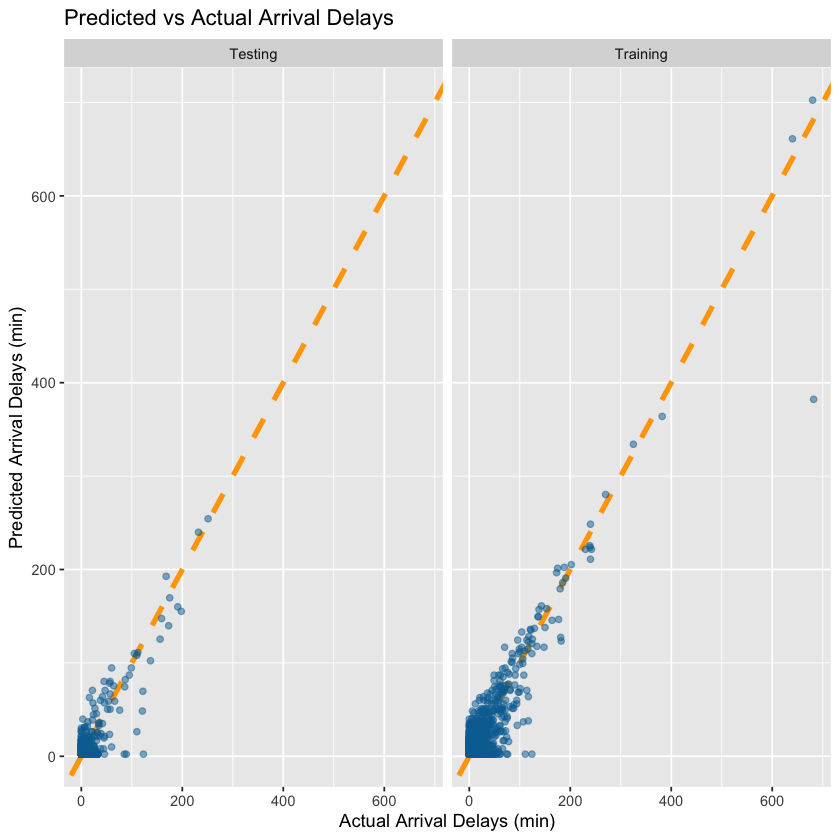

In [177]:
# Combine train and test predictions into one dataset
test_results <- test_results %>% mutate(train = "Testing")
train_results <- train_results %>% mutate(train = "Training")

combined_results <- bind_rows(train_results, test_results)

# Plot truth vs prediction
ggplot(combined_results, aes(x = truth, y = .pred)) +
  geom_abline(lty = 2, color = "orange", size = 1.5) +
  geom_point(color = "#006EA1", alpha = 0.5) +
  facet_wrap(~train) +
  labs(
    x = "Actual Arrival Delays (min)",
    y = "Predicted Arrival Delays (min)",
    title = "Predicted vs Actual Arrival Delays"
  )

The model performs well in both training and testing sets.
- Most points are closely clustered around the orange line, indicating the model fits the training data well.
- More spread around the orange line, especially for higher delays, which is expected.

Slight drop in R² from training to testing is expected and suggests low overfitting.
- A few outliers exist in the training plot, but overall, high R² (≈ 0.86) confirms a strong relationship between predicted and actual values.
- Still reasonably accurate in the testing plot, with an R² of ≈ 0.78, indicating the model generalizes fairly well.

Let's predict arrival delay minutes using two or more predictor variables: 'Departure Delay Minutes' and 'Late Arrival Delay. 

In [178]:
# Fit multi-linear regression model
train_fit3 <- lm_spec %>%
  fit(ArrDelayMinutes ~ DepDelayMinutes + LateAircraftDelay + WeatherDelay, data = train_data)

# Predictions on training data
train_results3 <- train_fit3 %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$ArrDelayMinutes)

# Predictions on testing data
test_results3 <- train_fit3 %>%
  predict(new_data = test_data) %>%
  mutate(truth = test_data$ArrDelayMinutes)

# RMSE & R² for training
rmse_train3 <- sqrt(mean((train_results3$truth - train_results3$.pred)^2))
rsq_train3 <- rsq(train_results3, truth = truth, estimate = .pred)

# RMSE & R² for testing
rmse_test3 <- sqrt(mean((test_results3$truth - test_results3$.pred)^2))
rsq_test3 <- rsq(test_results3, truth = truth, estimate = .pred)

# Print metrics
rmse_train3
rsq_train3
rmse_test3
rsq_test3

[1] 14.16465

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.8593942


[1] 14.07313

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7837837


Improve the model by using polynomial model.

In [179]:
# Fit a polynomial regression model (degree 3)
train_fit4 <- lm_spec %>%
  fit(ArrDelayMinutes ~ poly(DepDelayMinutes, 3), data = train_data)

# Predict on training data
train_results4 <- train_fit4 %>%
  predict(new_data = train_data) %>%
  mutate(truth = train_data$ArrDelayMinutes)

# Predict on test data
test_results4 <- train_fit4 %>%
  predict(new_data = test_data) %>%
  mutate(truth = test_data$ArrDelayMinutes)

# Load yardstick if not already loaded
library(yardstick)

# Compute RMSE and R² on training data
rmse_train4 <- sqrt(mean((train_results4$truth - train_results4$.pred)^2))
rsq_train4 <- rsq(train_results4, truth = truth, estimate = .pred)

# Compute RMSE and R² on test data
rmse_test4 <- sqrt(mean((test_results4$truth - test_results4$.pred)^2))
rsq_test4 <- rsq(test_results4, truth = truth, estimate = .pred)

# Output results
rmse_train4
rsq_train4
rmse_test4
rsq_test4

[1] 13.5391

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.871539


[1] 13.98324

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rsq,standard,0.7860218


- The polynomial model slightly improves the performance on both training and testing sets (lower RMSE, higher R²). However, the gain is marginal, suggesting limited non-linearity in the relationship between DepDelayMinutes and ArrDelayMinutes.
- There’s no sign of overfitting — the test performance remains close to training.

In [180]:
# Create 10 cross-validation folds
set.seed(1234)
cv_folds <- vfold_cv(train_data, v = 10)  

# Fit the model on each fold
results <- fit_resamples(                
  lm_spec,
  ArrDelayMinutes ~ DepDelayMinutes,
  resamples = cv_folds
)

# Collect aggregated metrics
results %>% collect_metrics()            

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,13.7116570,10,1.38901228,Preprocessor1_Model1
rsq,standard,0.8399461,10,0.01729215,Preprocessor1_Model1


This cross-validated model is your best-performing version so far. The model generalizes well across the folds more accurate and robust than the earlier linear and polynomial models.
- Lower RMSE (= 13.7) which is better than our earlier RMSEs.
- Higher R² (= 0.84) indicates a strong relationship between your predictors, suggesting cross-validation gives a more reliable estimate of performance.
- Low standard errors on both metrics confirm the stability and consistency of the model across folds.

In [186]:
# Create recipe
flight_recipe <- 
  recipe(ArrDelayMinutes ~ ., data = train_data)

# Define Ridge Regression model (L2 regularization)
# mixture = 0 for ridge, mixture = 1 for lasso, in between for elastic net
ridge_spec <- 
  linear_reg(penalty = 0.1, mixture = 0) %>%
  set_engine("glmnet")

# Create workflow
ridge_wf <- 
  workflow() %>%
  add_recipe(flight_recipe) %>%
  add_model(ridge_spec)

# Fit the Ridge model
ridge_fit <- ridge_wf %>%
  fit(data = train_data)

# Extract coefficients
ridge_fit %>%
  pull_workflow_fit() %>%
  tidy()

Warning message:
“`pull_workflow_fit()` was deprecated in workflows 0.2.3.
ℹ Please use `extract_fit_parsnip()` instead.”


term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),2.87656977,0.1
DepDelayMinutes,0.72380870,0.1
CarrierDelay,0.20005080,0.1
WeatherDelay,0.23642348,0.1
NASDelay,0.49401053,0.1
SecurityDelay,0.29577843,0.1
LateAircraftDelay,0.19907893,0.1
DayOfWeek,0.09511114,0.1
Month,-0.11257505,0.1


This table suggests that departure delays, NAS delays, and security delays are key contributors to arrival delay. Regularization has shrunk the coefficients compared to an unregularized linear model, helping prevent overfitting.
- DepDelayMinutes has the strongest positive effect (~0.72), meaning it’s the most influential predictor of arrival delays.
- Month is slightly negative (~−0.11), possibly indicating delays vary seasonally.

In [187]:
# Define Lasso spec (mixture = 1 for Lasso)
lasso_spec <- linear_reg(penalty = 0.1, mixture = 1) %>%
  set_engine("glmnet")

# Build the workflow
lasso_wf <- workflow() %>%
  add_recipe(flight_recipe) %>%
  add_model(lasso_spec)

# Fit the model to training data
lasso_fit <- lasso_wf %>%
  fit(data = train_data)

# View model coefficients
lasso_fit %>%
  pull_workflow_fit() %>%
  tidy()

term,estimate,penalty
<chr>,<dbl>,<dbl>
(Intercept),1.82078770,0.1
DepDelayMinutes,0.90221912,0.1
CarrierDelay,0.02663978,0.1
WeatherDelay,0.05589779,0.1
NASDelay,0.43846072,0.1
SecurityDelay,0.05153864,0.1
LateAircraftDelay,0.02455799,0.1
DayOfWeek,0.00000000,0.1
Month,-0.05531991,0.1


- Lasso (L1) tends to shrink less relevant features to zero, like DayOfWeek, helping in feature selection.
- Compared to Ridge (L2), Lasso is better when you suspect some features might not be useful.
- DepDelayMinutes and NASDelay remain dominant predictors.

Implementing Lasso Regression with hyperparameter tuning using grid search is a very effective way to select the optimal penalty (λ) value for regularization.

In [192]:
# Define the Lasso model with a tunable penalty
tune_spec <- linear_reg(penalty = tune(), mixture = 1) %>%
  set_engine("glmnet")

# Define cross-validation
flight_cvfolds <- vfold_cv(train_data)

# Set up grid for lambda (penalty)
lambda_grid <- grid_regular(
  penalty(range = c(-3, 0.3)),  # log10 scale: 10^-3 to 10^0.3
  levels = 50
)

# Rebuild the workflow with the *tunable* model spec
lasso_wf <- workflow() %>%
  add_recipe(flight_recipe) %>%
  add_model(tune_spec)

# Tune over the grid
lasso_grid <- tune_grid(
  lasso_wf,
  resamples = flight_cvfolds,
  grid = lambda_grid
)

# Display the best result by RMSE
show_best(lasso_grid, metric = "rmse")

penalty,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.4632082,rmse,standard,12.58455,10,1.624377,Preprocessor1_Model48
1.2530234,rmse,standard,12.58655,10,1.643774,Preprocessor1_Model47
1.7086498,rmse,standard,12.59004,10,1.601966,Preprocessor1_Model49
1.0730309,rmse,standard,12.59304,10,1.660336,Preprocessor1_Model46
0.9188938,rmse,standard,12.60284,10,1.674801,Preprocessor1_Model45


- The lowest RMSE from our Lasso grid search is around 12.58 (best-performing model).
- The optimal penalty (lambda)is 1.4632082
- The standard errors are relatively small, suggesting stable estimates across the folds.

In [196]:
# Select best lambda
best_lambda <- select_best(lasso_grid, metric = "rmse")

# Finalize workflow with best lambda
final_lasso_wf <- finalize_workflow(lasso_wf, best_lambda)

# Fit final model to training data
final_lasso_fit <- final_lasso_wf %>% fit(data = train_data)

# Optionally evaluate on test set
final_predictions <- predict(final_lasso_fit, new_data = test_data) %>%
  bind_cols(test_data)

# Evaluate performance
metrics(final_predictions, truth = ArrDelayMinutes, estimate = .pred)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,12.8421054
rsq,standard,0.8210817
mae,standard,7.3186631
